Epoch[1/5], Train Loss: 18420.7906, Val Loss: 12618.1825


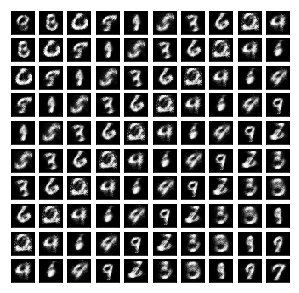

Epoch[2/5], Train Loss: 11133.9191, Val Loss: 9907.6931


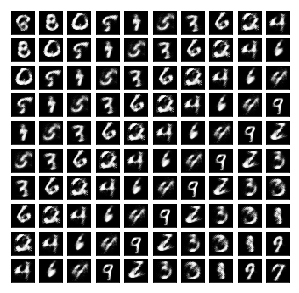

Epoch[3/5], Train Loss: 9156.2598, Val Loss: 8460.7893


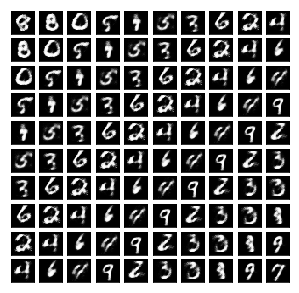

Epoch[4/5], Train Loss: 8065.4690, Val Loss: 7780.5073


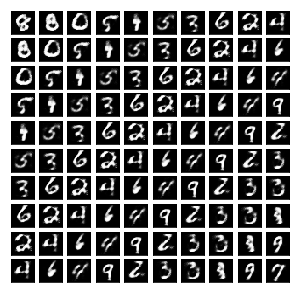

Epoch[5/5], Train Loss: 7558.6807, Val Loss: 7432.3756


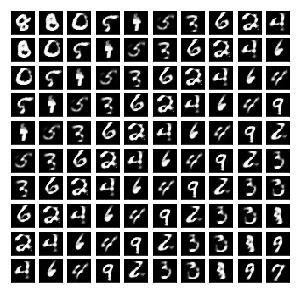

In [1]:
""" (Autoencoder)
Standard Autoencoder

Autoencoders take an input representation, encode it into a reduced dimensionality
space using an 'encoder network', and then decode it using a 'decoder network' back
to its original representation
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Encoder(nn.Module):
    """ Feedforward network encoder. Input is an image, output is encoded 
    vector representation of that image.
    """
    def __init__(self, image_size, hidden_dim):
        super(Encoder, self).__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        
    def forward(self, x):
        return F.relu(self.linear(x))


class Decoder(nn.Module):
    """ Feedforward network decoder. Input is an encoded vector representation, 
    output is reconstructed image.
    """
    def __init__(self, hidden_dim, image_size):
        super(Decoder, self).__init__()
        
        self.linear = nn.Linear(hidden_dim, image_size)
        
    def forward(self, encoder_output):
        return torch.sigmoid(self.linear(encoder_output))


class Autoencoder(nn.Module):
    """ Autoencoder super class to encode then decode an image
    """
    def __init__(self, image_size=784, hidden_dim=32):
        super().__init__()
        
        self.encoder = Encoder(image_size=image_size, hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim, image_size=image_size)
                     
    def forward(self, x):
        return self.decoder(self.encoder(x))


class AutoencoderTrainer:
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        """ Object to hold data iterators, train the model """
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.debugging_image, _ = next(iter(val_iter))
        self.viz = viz
    
    def train(self, num_epochs, lr=1e-3, weight_decay=1e-5):
        """ Train a Variational Autoencoder
            Logs progress using total loss, reconstruction loss, kl_divergence, and validation loss

        Inputs:
            num_epochs: int, number of epochs to train for
            lr: float, learning rate for Adam optimizer (default 1e-3)
            weight_decay: float, weight decay for Adam optimizer (default 1e-5)
        """   
        
        # Initialize best validation loss for early stopping
        best_val_loss = 1e10
        
        # Adam optimizer, sigmoid cross entropy for reconstructing binary MNIST
        optimizer = torch.optim.Adam(params=[p for p in self.model.parameters() if p.requires_grad], 
                                     lr=lr, 
                                     weight_decay=weight_decay)
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            
            self.model.train()
            epoch_loss = []
            
            for batch in self.train_iter:
                
                # Zero out gradients
                optimizer.zero_grad()
                
                # Compute reconstruction loss, Kullback-Leibler divergence for a batch
                batch_loss = self.compute_batch(batch)
                
                # Update parameters
                batch_loss.backward()
                optimizer.step()
                
                # Log metrics
                epoch_loss.append(batch_loss.item())
            
            # Test the model on the validation set
            val_loss = self.evaluate(self.val_iter)
            
            # Early stopping
            if val_loss < best_val_loss:
                self.best_model = deepcopy(self.model)
                best_val_loss = val_loss
                
            # Progress logging
            print ("Epoch[%d/%d], Train Loss: %.4f, Val Loss: %.4f" 
                   %(epoch, num_epochs, np.mean(epoch_loss), val_loss))
            
            # Debugging and visualization purposes
            if self.viz:
                self.reconstruct_images(self.debugging_image, epoch)
                plt.show()
                
    def compute_batch(self, batch):
        """ Compute loss for a batch of examples """
        images, _ = batch
        images = to_cuda(images.view(images.shape[0], -1))
        
        output = self.model(images)
        
        recon_loss = F.binary_cross_entropy(output, images, reduction='sum')
        
        return recon_loss
    
    def evaluate(self, iterator):
        """ Evaluate on a given dataset """
        return np.mean([self.compute_batch(batch).item() for batch in iterator])
    
    def reconstruct_images(self, images, epoch, save=True):
        """Reconstruct a fixed input at each epoch for progress visualization """
        # Reshape images, VAE output
        images = to_cuda(images.view(images.shape[0], -1))
        reconst_images = self.model(images)
        reconst_images = reconst_images.view(reconst_images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(reconst_images.shape[0]**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(reconst_images[i+j].data.numpy(), cmap='gray')
        
        # Save
        if save:
            outname = '../viz/' + trainer.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(trainer.debugging_image.data,
                                         outname + 'real.png',
                                         nrow=size_figure_grid)
            torchvision.utils.save_image(reconst_images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png' %(epoch),
                                         nrow=size_figure_grid)
    
    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model. If model not specified, instantiate it """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = Autoencoder(image_size=784, 
                    hidden_dim=32)

trainer = AutoencoderTrainer(model=model,
                             train_iter=train_iter, 
                             val_iter=val_iter, 
                             test_iter=test_iter,
                             viz=True)

trainer.train(num_epochs=5,
              lr=1e-3,
              weight_decay=1e-5)